In [1]:
from shapely import wkt
import geopandas as gpd

wkt_string = "POLYGON((-110.958131 45.674319, -110.316804 45.674319, -110.316804 45.240848, -110.958131 45.240848, -110.958131 45.674319))"
gdf = gpd.GeoDataFrame(geometry=[wkt.loads(wkt_string)])
bbox = gdf.total_bounds

In [2]:
import dask.distributed
from matplotlib.colors import ListedColormap
import pystac_client

import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import planetary_computer
import rasterio
import rasterio.features
import stackstac
import xarray as xr
import rasterio as rio
import rioxarray

In [3]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [4]:
search = catalog.search(collections=["io-lulc-annual-v02"], bbox=bbox)
items = search.item_collection()

# The STAC metadata contains some information we'll want to use when creating
# our merged dataset. Get the EPSG code of the first item and the nodata value.
item = items[0]

# Create a single DataArray from out multiple with the corresponding
# rasters projected to a single CRS. Note that we set the dtype to ubyte, which
# matches our data, since stackstac will use float64 by default.
stack = (
    stackstac.stack(
        items,
        dtype=np.int64,
        #dtype=np.ubyte,
        fill_value=255,
        bounds_latlon=bbox,
        sortby_date=False,
        #rescale=False,
    )
    .assign_coords(
        time=pd.to_datetime([item.properties["start_datetime"] for item in items])
        .tz_convert(None)
        .to_numpy()
    )
    .sortby("time")
)

client = dask.distributed.Client()
# print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")

/opt/conda/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34717 instead
  warnings.warn(


In [35]:
merged = stack.squeeze().compute()
ds = xr.where(merged == 7, 1, 0)
diff_ds = ds.isel(time=[6]).squeeze() - ds.isel(time=[0]).squeeze()


In [58]:
#diff_ds.plot()
diff_ds.rio.to_raster("diffs.tif", driver="COG")


In [59]:
diff_ds= diff_ds.rio.write_crs(diff_ds.epsg.item())
built_area = diff_ds.rio.reproject("EPSG:4326")

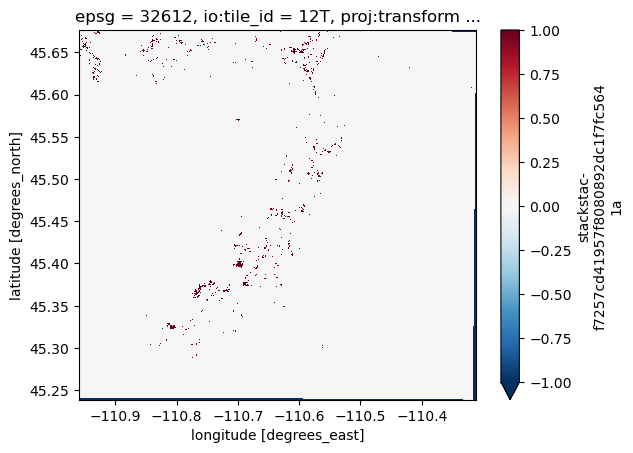

In [37]:
built_area.plot()

In [60]:

built_area.rio.to_raster("built_area.tif", driver="COG")

from huggingface_hub import HfApi, login
import streamlit as st
login(st.secrets["HF_TOKEN"], add_to_git_credential=False)
api = HfApi()

def hf_upload(file):
    info = api.upload_file(
            path_or_fileobj=file,
            path_in_repo=file,
            repo_id="boettiger-lab/yellowstone",
            repo_type="dataset",
        )
hf_upload("built_area.tif")

url = "https://huggingface.co/datasets/boettiger-lab/yellowstone/resolve/main/built_area.tif"

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/jovyan/.cache/huggingface/token
Login successful


No files have been modified since last commit. Skipping to prevent empty commit.


In [61]:
hf_upload("diffs_cog.tif")


diffs_cog.tif:   0%|          | 0.00/183M [00:00<?, ?B/s]

In [64]:
import leafmap.maplibregl as leafmap
m = leafmap.Map(center=(-110.6, 45.45), zoom=10, style="positron")
m.add_layer_control()

url = "https://huggingface.co/datasets/boettiger-lab/yellowstone/resolve/main/diffs_cog.tif"

m.add_basemap("Esri.NatGeoWorldMap")
m.add_cog_layer(url, fit_bounds=False)
m.to_html("docs/paradise.html", overwrite = True, opacity=0.8)
m

Map(height='600px', map_options={'bearing': 0, 'center': (-110.6, 45.45), 'pitch': 0, 'style': 'https://tiles.…